Extended Source Fitting
===================
*J. W. Hewitt, UMBC/GSFC*

Analyzing the Extension of LAT Sources
----------------

WARNING: This tutorial is being updated for Pass 8. The method is correct, but the files need to be updated.

The purpose of this tutorial is to demonstrate one method to fit the extension of a spatially resolved source within the likelihood analysis framework.

For an introduction to fitting extended source templates, see the FSSC tutorial:
http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/extended/extended.html

For a detailed discussion of fitting source extension using LAT data, including Monte Carlo validations, see Lande et al. (2012):
http://adsabs.harvard.edu/abs/2012ApJ...756....5L

For this tutorial we will make use of the Extended Source templates: http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/LAT_extended_sources_v15.tgz

## Extension significance

Just as we can use a test-statistic to establish the significance of a point source, we can define a quantity that measures the significance of source extension:

<img src="tsext.gif">

Here the null hypothesis is that of a point source, with the position localized by gtfindsrc. Below we will see how to scan over the likelihood space of the extended source hypothesis.


### Setup our analysis

Files for this analysis are temporarily available here: 


In our analysis we will use two XML files.

    inputxml: has been fit to the ROI with a point source model for HB9.
    diskxml: includes an extended disk tempalte as a spatial map for HB9.
    
The inputxml file includes a point source model for HB9. We will fit this hypothesis and use the resulting loglikelihood as our null hypothesis in computing TSext.

We then scan the likelihood space by fitting the disk template at the same center, but for different disk radii. In practice, we should also vary the disk centroid to account for the source localization, but this is excluded here for simplicity.

For the spatial template we will use a uniform disk, described by:
<img src="uniformdisk.gif">

You can encode any spatial distribution you like into a FITS file and pass this into the ScienceTools as a spatial map. For this example we will makes use of the pre-defined extended spatial templates included with 2FGL. Here we use the uniform disk template for the SNR W30 (W30.fits), but a gaussian (e.g. IC443.fits) or any other spatial template written to FITS can also be used.

In all fits we leave the normalization of the Galactic and isotropic diffuse components free, the normalization and index of the source representing HB9, as well as the normalization of the nearby source.

In [4]:
mysource = 'HB9'
inputxml = 'model_HB9_point.xml'
diskxml = 'model_HB9_diskfit.xml'

In [5]:
from gt_apps import *
srcMaps['srcmdl']= inputxml
srcMaps['outfile']='srcMaps_HB9_1-300gev_6bins.fits'
srcMaps['cmap']='CountsMap3D_HB9_1-300gev_6bins.fits'
srcMaps['irfs']= 'P8R2_SOURCE_V6'
srcMaps['scfile']= 'HB9_SC.fits'
srcMaps['bexpmap']= 'bexpmap_HB9_1-300gev_6bins.fits'
srcMaps['expcube']= 'expCube_both1-300gev.fits'
srcMaps['rfactor']= 4
srcMaps['emapbnds']= 'no'
srcMaps['clobber']= True
srcMaps.command()
#srcMaps.run() #uncomment this line if you really want to generate this sourcemap

'time -p /software/Glast/ScienceTools-v9r32p5-fssc-20130916-x86_64-apple-darwin12.4.0/x86_64-apple-darwin12.4.0/bin/gtsrcmaps scfile=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/HB9_P7REP_ft2.fits sctable="SC_DATA" expcube=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/expCube_both1-300gev.fits cmap=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/CountsMap3D_HB9_P7REP_both1-300gev_6bins.fits srcmdl=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/model_HB9_P7REP_2fgl_point.xml bexpmap=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/bexpmap_HB9_P7REP_both1-300gev_6bins.fits outfile=/Users/jhewitt/Dropbox/Public/hb9_lat_analysis/srcMaps_HB9_P7REP_both1-300gev_6bins.fits irfs="P7REP_SOURCE_V15" convol=yes resample=yes rfactor=2 minbinsz=0.1 ptsrc=yes psfcorr=yes emapbnds=no copyall=no chatter=2 clobber=True debug=no gui=no mode="ql"'

In [7]:
from BinnedAnalysis import *
obs = BinnedObs(srcMaps='srcMaps_HB9_1-300gev_6bins.fits',
                binnedExpMap=wd+'bexpmap_HB9_1-300gev_6bins.fits', 
                expCube=wd+'expCube_1-300gev.fits',
                irfs='P8R2_SOURCE_V6')

analysis = BinnedAnalysis(obs, srcModel=inputxml, optimizer='NEWMINUIT')

In [8]:
#### Record the null hypothesis for the point source fit
null_hyp = analysis.fit(0)
print "Null hypothesis is LLps = ",null_hyp

Null hypothesis is LLps =  146276.205795


### Scan the likelihood space for different disk radii

Now we want to scan the likelihood space as a function of disk radius. To do so we repeat a binned likelihood fit of the ROI stepping through some radial extent. The step size should be chosen to be sufficiently small the sample the LAT PSF. Typically 0.03 degrees is sufficient. 

The XML source model that is present in the diskxml file but not the inputxml file is:
<img src="xmlmodel.png">

<source name="HB9" type="DiffuseSource">
  <spectrum type="PowerLaw">
    <parameter error="0.695" free="1" max="1000000" min="1e-06" name="Prefactor" scale="1e-12" value="6.59" />
    <parameter error="0.192" free="1" max="5" min="0" name="Index" scale="-1" value="3.010" />
    <parameter free="0" max="500000" min="30" name="Scale" scale="1" value="2000" />
  </spectrum>
  <spatialModel file="/data/fermi/hb9_10deg/uniform_disk.fits" type="SpatialMap">
    <parameter free="0" max="1000" min="0.001" name="Prefactor" scale="1" value="1" />
  </spatialModel>
</source>

In [ ]:
import pyfits

# open disk template of W30 for use as HB9
image = pyfits.open('W30.fits')

# change centroid to that of HB9
print image.info()
image[0].header['CRVAL1'] = 75.166667
image[0].header['CRVAL2'] = 46.609722

# change disk radius through pixel scale to match SNR
radius_in_degrees = 1.08
radius_in_pixels = 32
image[0].header['CDELT1'] = radius_in_degrees/radius_in_pixels
image[0].header['CDELT2'] = radius_in_degrees/radius_in_pixels

# renormalize template
sum = 0
for element in image[0].data.flat:
  sum += element

norm = sum * (m.pi/180)**2 * (0.1**2)
for x,row in enumerate(image[0].data):
  for y in enumerate(row):
   image[0].data[x,y[0]] /= norm
 
image.writeto('uniform_disk.fits')
image.close()

Since we will be rescaling the disk radius frequently, let's write a function to do this.

In [ ]:
import pyfits
def scale_disk(fits_template,radius_in_degrees):
    image = pyfits.open(fits_template)
    radius_in_pixels = 32
    image[0].header['CDELT1'] = radius_in_degrees/radius_in_pixels
    image[0].header['CDELT2'] = radius_in_degrees/radius_in_pixels
    image.writeto(template,clobber=True)
    image.close()

Now let's loop over some range of radii, recording the global loglikelihood. Note that this will take quite some time... Make sure that at each step you see the message "Generating SourceMap for HB9....................!". The HB9 spatial template is changing and needs to be recomputed for each fit of the sourcemap. By excluding HB9 from the initial sourcemap, I've save some time so that only HB9 is recomputed at each step, and not all sources in the sourcemap (the diffuse usually takes the longest time).

In [ ]:
n_steps = 9
step_size = 0.1 # in degrees
initial_radius = 1.3
template = 'uniform_disk.fits'

hb9_radius = []
hb9_flux = []
hb9_index = []
hb9_ll = []
for radius in ((x-n_steps/2)*step_size+initial_radius for x in range(0,n_steps)):
    print "Fitting disk radius = ",radius
    scale_disk(template,radius)
    mylike = BinnedAnalysis(obs,diskxml,optimizer='NEWMINUIT')
    hb9_ll.append(mylike.fit(0))
    hb9_radius.append(radius)
    hb9_flux.append(mylike.normPar('HB9').getTrueValue())
    hb9_index.append(mylike[mylike.par_index('HB9','Index')])
    del mylike

Now we can plot the Global LogLikelihood as a function of radius, and calculate TSext for the best-fit radius.

In [ ]:
TSext = -2*(min(hb9_ll)-null_hyp)
print "HB9 has TSext = ",TSext," for a radius of ", hb9_radius[hb9_ll.index(min(hb9_ll))]

Populating the interactive namespace from numpy and matplotlib


NameError: name 'hb9_ll' is not defined

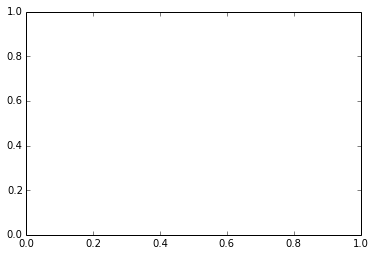

In [3]:
%pylab inline
fig = plt.figure()
ax = fig.add_subplot(111)
hb9_tsext = [ -2*(hb9_ll[x]-null_hyp) for x in range(len(hb9_ll)) ]
p = ax.plot(hb9_radius, hb9_tsext, 'b')
ax.set_xlabel('Disk Radius (degrees)')
ax.set_ylabel('TSext')
ax.set_title('Radius vs TSext')
fig.show()

print "HB9 has a best-fit radius = ",hb9_radius[hb9_ll.index(min(hb9_ll))]," with an error of ??? degrees."

print "Homework:"
print "Determine the statistical error on extension by finding the 68% confidence interval in the plot of TSext vs Radius."